In [2]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pymaster as nmt
import astropy.io.fits as fits

In [3]:
def apply_mask(map, mask):
    masked_index = np.where(mask != 1)
    masked_map = map.copy()
    masked_map[masked_index] = hp.UNSEEN
    masked_map = hp.ma(masked_map)
    #masked_map.mask = mask
    return masked_map

def calc_fsky(mask):
    return np.sum(mask**2)/len(mask)

In [4]:
def compute_power_spectrum(map1, ellmax, map2 = None, fsky = None):
    if map2 is not None:
        cl = hp.anafast(map1, map2, lmax= ellmax)
    else:
        cl = hp.anafast(map1, lmax= ellmax)
    if fsky is not None:
        cl /= fsky
    return cl

In [5]:
def normalize_cl(cl):
    ells = np.arange(len(cl))
    return cl *(ells * (ells + 1))/ (2*np.pi )

In [23]:
def abs_diff(x, y):
    return (x - y)

def ratio_diff(x, y):
    return 100*(x - y)/y

In [74]:
nilc_cmb_path = '/home/yunan/COM_CMB_IQU-nilc_2048_R3.00_full.fits'

In [7]:
fits_file = fits.open(nilc_cmb_path)
fits_header = fits_file[1].header
fits_header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   32 / width of table in bytes                        
NAXIS2  =             50331648 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    8 / number of fields in each row                   
COMMENT  -------------------------------------------------------------          
COMMENT  Products from NILC component separation method                         
COMMENT  -------------------------------------------------------------          
COMMENT  Further details in the Planck Legacy Archive and Explanatory Supplement
COMMENT  http://www.cosmos.e

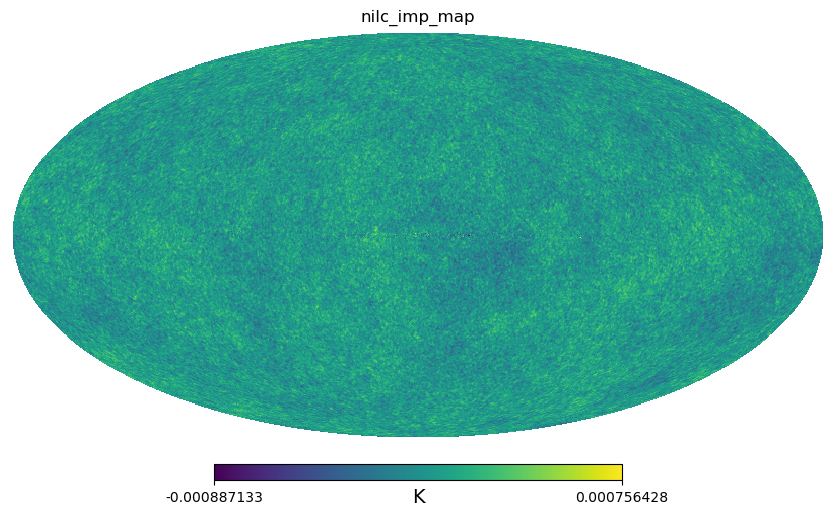

In [8]:
nilc_imp_map = fits_file[1].data['I_STOKES']
nilc_imp_map = hp.reorder(nilc_imp_map, n2r=True)
hp.mollview(nilc_imp_map, title='nilc_imp_map', unit='K')

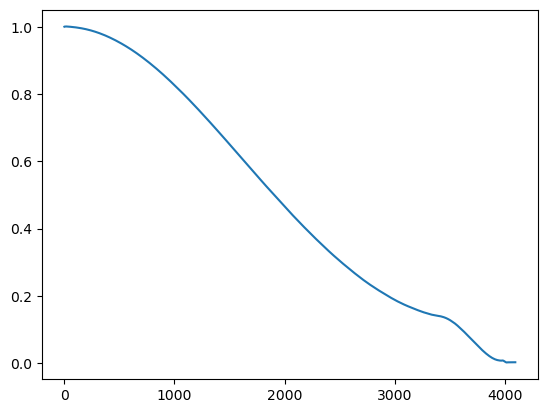

In [10]:
nilc_beam = fits_file[2].data['INT_BEAM']
nilc_beam[0] = 1
nilc_beam[1] = 0.99999962
plt.plot(nilc_beam)

In [13]:
nilc_map_alm =      hp.map2alm(nilc_imp_map, lmax=4096)
nilc_map_alm_beam = hp.almxfl(nilc_map_alm, 1/nilc_beam)
filtered_nilc_map = hp.alm2map(nilc_map_alm_beam, nside = 2048)

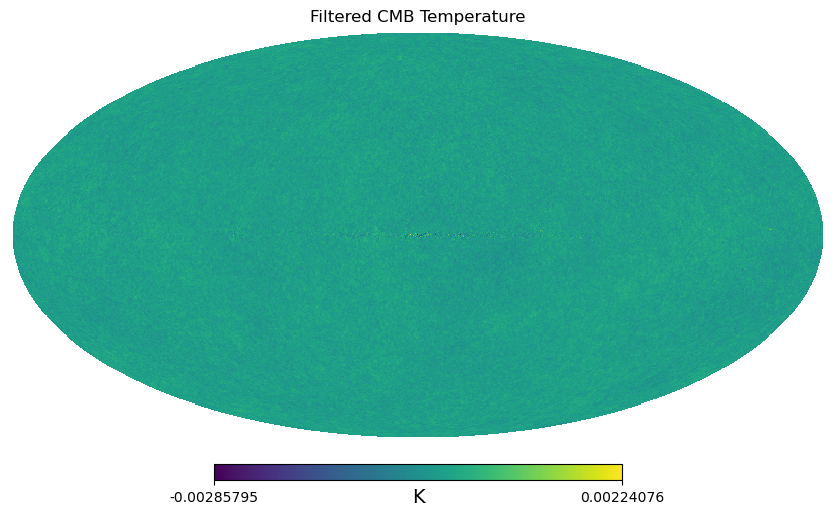

In [14]:
hp.mollview(filtered_nilc_map, title='Filtered CMB Temperature', unit='K')

In [15]:
mask_path = '/home/yunan/planck_release/planck_mask.fits'
mask = hp.read_map(mask_path)

In [16]:
raw_nilc_cl = compute_power_spectrum(filtered_nilc_map, 4096)
masked_nilc_map = apply_mask(filtered_nilc_map, mask)
fsky=calc_fsky(mask)
masked_nilc_cl = compute_power_spectrum(masked_nilc_map, 4096, fsky=fsky)

In [75]:
raw_nilc_dl = normalize_cl(raw_nilc_cl)
masked_nilc_dl = normalize_cl(masked_nilc_cl)
filtered_nilc_dl = normalize_cl(raw_nilc_cl)
masked_filtered_nilc_dl = normalize_cl(masked_nilc_cl)

In [19]:
ell, planck_dl, delta_minus_dl, delta_plus_dl = np.genfromtxt('/home/yunan/COM_PowerSpect_CMB-TT-full_R3.01.txt', unpack=True)

In [20]:
apodized_mask = nmt.mask_apodization(mask, 2, apotype='C2')

In [21]:
apodized_masked_nilc_map = apply_mask(filtered_nilc_map, apodized_mask)
fsky_apodized = calc_fsky(apodized_mask)
apodized_masked_nilc_cl = compute_power_spectrum(apodized_masked_nilc_map, 4096, fsky=fsky_apodized)
apodized_filtered_nilc_dl = normalize_cl(apodized_masked_nilc_cl)

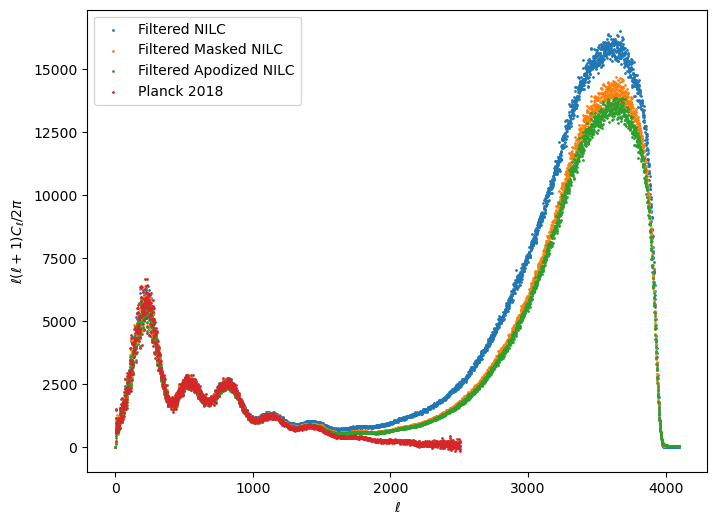

In [76]:
ells = np.arange(len(raw_nilc_dl))
plt.figure(figsize=(8, 6))
plt.scatter(ells, filtered_nilc_dl*1e12,          s = 1 ,label='Filtered NILC')
plt.scatter(ells, masked_filtered_nilc_dl*1e12,   s = 1 ,label='Filtered Masked NILC')
plt.scatter(ells, apodized_filtered_nilc_dl*1e12, s = 1 ,label='Filtered Apodized NILC')
plt.scatter(ell , planck_dl,                      s = 1 ,label='Planck 2018')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')
plt.legend()
plt.show()

In [24]:
filteted_abs_diff = abs_diff(filtered_nilc_dl[:2507]*1e12, planck_dl)
filteted_ratio_diff = ratio_diff(filtered_nilc_dl[:2507]*1e12, planck_dl)
masked_abs_diff = abs_diff(masked_filtered_nilc_dl[:2507]*1e12, planck_dl)
masked_ratio_diff = ratio_diff(masked_filtered_nilc_dl[:2507]*1e12, planck_dl)
apodized_abs_diff = abs_diff(apodized_filtered_nilc_dl[:2507]*1e12, planck_dl)
apodized_ratio_diff = ratio_diff(apodized_filtered_nilc_dl[:2507]*1e12, planck_dl)


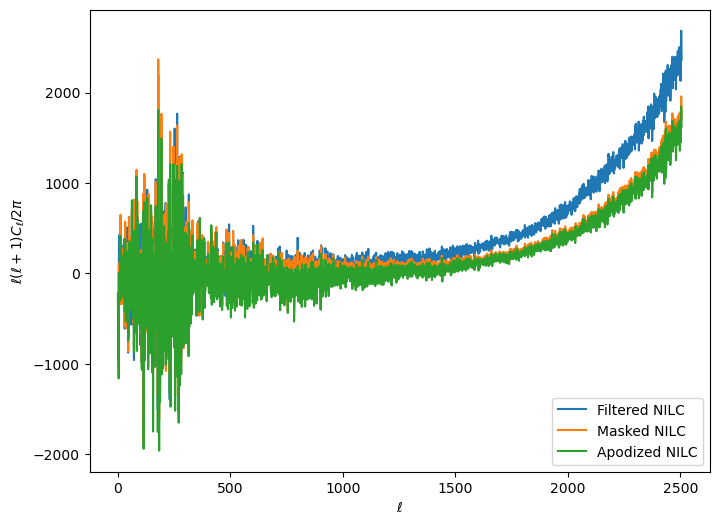

In [25]:
plt.figure(figsize=(8, 6))
plt.plot(ells[:2507], filteted_abs_diff, label='Filtered NILC')
plt.plot(ells[:2507], masked_abs_diff, label='Masked NILC')
plt.plot(ells[:2507], apodized_abs_diff, label='Apodized NILC')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')
plt.legend()
plt.show()

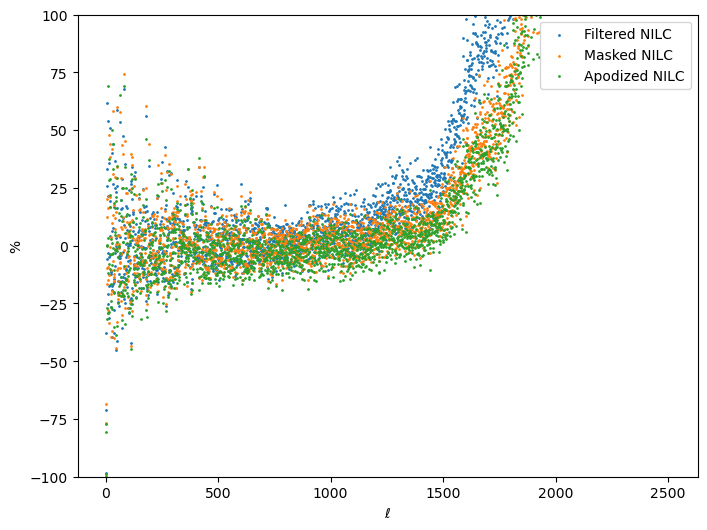

In [26]:
plt.figure(figsize=(8, 6))
plt.scatter(ells[:2507], filteted_ratio_diff, s = 1,label='Filtered NILC')
plt.scatter(ells[:2507], masked_ratio_diff,   s = 1,label='Masked NILC'  )
plt.scatter(ells[:2507], apodized_ratio_diff, s = 1,label='Apodized NILC')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\%$')
plt.ylim(-100, 100)
plt.legend()
plt.show()

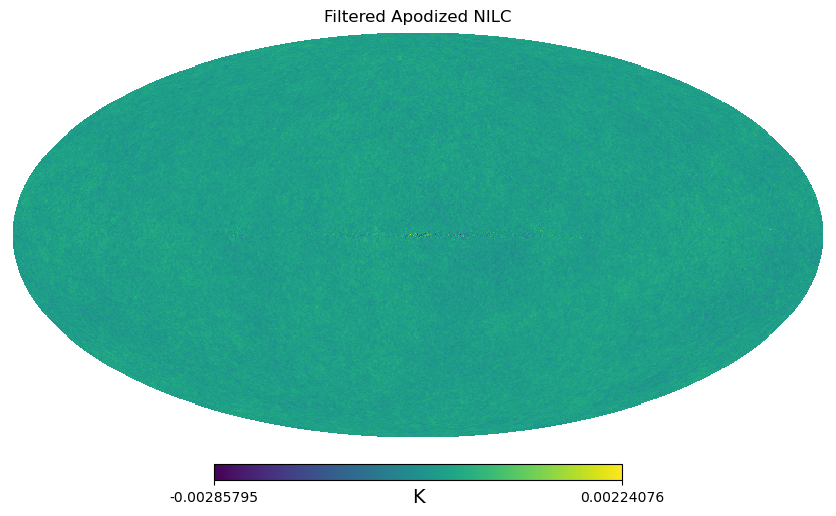

In [77]:
hp.mollview(filtered_nilc_map, title='Filtered Apodized NILC', unit='K')

In [28]:
nilc_hm1_path = '/home/yunan/planck_release/half_mission/COM_CMB_IQU-nilc_2048_R3.00_hm1.fits'
nilc_hm2_path = '/home/yunan/planck_release/half_mission/COM_CMB_IQU-nilc_2048_R3.00_hm2.fits'
nilc_hm1_map = hp.read_map(nilc_hm1_path, field=(0, 1, 2))
nilc_hm2_map = hp.read_map(nilc_hm2_path, field=(0, 1, 2))

In [ ]:
filtered_nilc_hm1_alm_temp =  hp.map2alm(nilc_hm1_map[0], lmax=4096)
filtered_nilc_hm1_alm_temp =  hp.almxfl(filtered_nilc_hm1_alm_temp, 1/nilc_beam)
filtered_nilc_hm1_map =       hp.alm2map(filtered_nilc_hm1_alm_temp, nside = 2048)
filtered_nilc_hm2_alm_temp = hp.map2alm(nilc_hm2_map[0], lmax=4096)
filtered_nilc_hm2_alm_temp = hp.almxfl(filtered_nilc_hm2_alm_temp, 1/nilc_beam)
filtered_nilc_hm2_map =      hp.alm2map(filtered_nilc_hm2_alm_temp, nside=2048)
masked_nilc_hm1_map = apply_mask(filtered_nilc_hm1_map, mask)
masked_nilc_hm2_map = apply_mask(filtered_nilc_hm2_map, mask)
apodized_masked_nilc_hm1_map = apply_mask(filtered_nilc_hm1_map, apodized_mask)
apodized_masked_nilc_hm2_map = apply_mask(filtered_nilc_hm2_map, apodized_mask)


raw_nilc_hm1_cl = compute_power_spectrum(filtered_nilc_hm1_map, 4096)
raw_nilc_hm2_cl = compute_power_spectrum(filtered_nilc_hm2_map, 4096)
masked_nilc_hm1_cl = compute_power_spectrum(masked_nilc_hm1_map, 4096, fsky=fsky)
masked_nilc_hm2_cl = compute_power_spectrum(masked_nilc_hm2_map, 4096, fsky=fsky)
apodized_masked_nilc_hm1_cl = compute_power_spectrum(apodized_masked_nilc_hm1_map, 4096, fsky=fsky_apodized)
apodized_masked_nilc_hm2_cl = compute_power_spectrum(apodized_masked_nilc_hm2_map, 4096, fsky=fsky_apodized)
raw_nilc_hm1_dl = normalize_cl(raw_nilc_hm1_cl)
raw_nilc_hm2_dl = normalize_cl(raw_nilc_hm2_cl)
masked_nilc_hm1_dl = normalize_cl(masked_nilc_hm1_cl)
masked_nilc_hm2_dl = normalize_cl(masked_nilc_hm2_cl)
apodized_masked_nilc_hm1_dl = normalize_cl(apodized_masked_nilc_hm1_cl)
apodized_masked_nilc_hm2_dl = normalize_cl(apodized_masked_nilc_hm2_cl)

raw_nilc_hm12_cl = compute_power_spectrum(filtered_nilc_hm1_map, 4096, filtered_nilc_hm2_map)
masked_nilc_hm12_cl = compute_power_spectrum(masked_nilc_hm1_map, 4096, masked_nilc_hm2_map, fsky=fsky)
apodized_masked_nilc_hm12_cl = compute_power_spectrum(apodized_masked_nilc_hm1_map, 4096, apodized_masked_nilc_hm2_map, fsky=fsky_apodized)
raw_nilc_hm12_dl = normalize_cl(raw_nilc_hm12_cl)
masked_nilc_hm12_dl = normalize_cl(masked_nilc_hm12_cl)
apodized_masked_nilc_hm12_dl = normalize_cl(apodized_masked_nilc_hm12_cl)


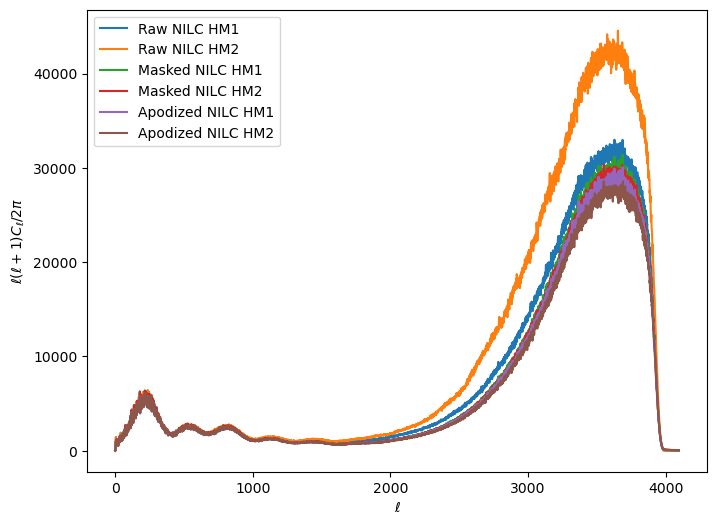

In [30]:
plt.figure(figsize=(8, 6))
plt.plot(ells, raw_nilc_hm1_dl*1e12, label='Raw NILC HM1')
plt.plot(ells, raw_nilc_hm2_dl*1e12, label='Raw NILC HM2')
plt.plot(ells, masked_nilc_hm1_dl*1e12, label='Masked NILC HM1')
plt.plot(ells, masked_nilc_hm2_dl*1e12, label='Masked NILC HM2')
plt.plot(ells, apodized_masked_nilc_hm1_dl*1e12, label='Apodized NILC HM1')
plt.plot(ells, apodized_masked_nilc_hm2_dl*1e12, label='Apodized NILC HM2')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')
plt.legend()
plt.show()


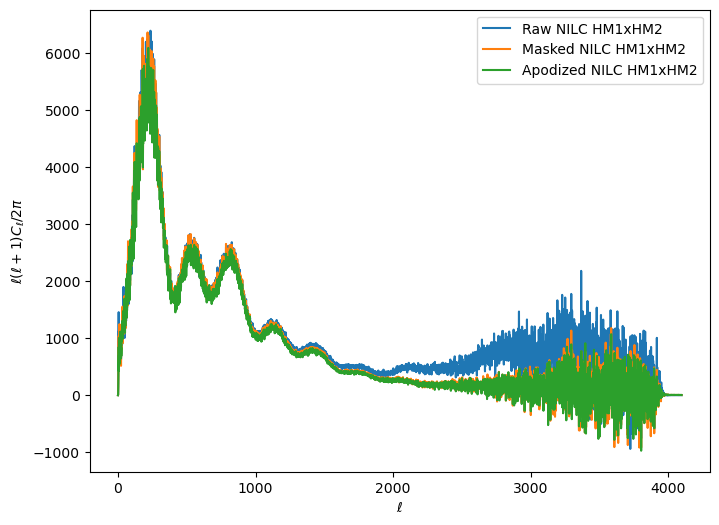

In [31]:
plt.figure(figsize=(8, 6))
plt.plot(ells, raw_nilc_hm12_dl*1e12, label='Raw NILC HM1xHM2')
plt.plot(ells, masked_nilc_hm12_dl*1e12, label='Masked NILC HM1xHM2')
plt.plot(ells, apodized_masked_nilc_hm12_dl*1e12, label='Apodized NILC HM1xHM2')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')
plt.legend()
plt.show()

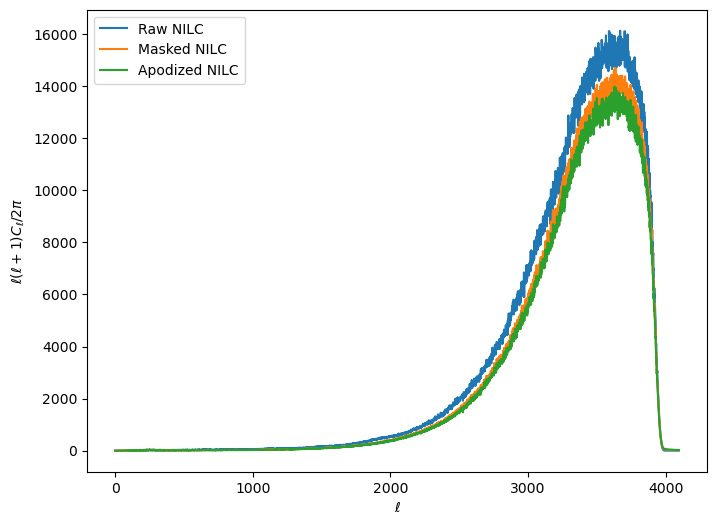

In [32]:
raw_noise_bias = raw_nilc_dl - raw_nilc_hm12_dl
masked_noise_bias = masked_nilc_dl - masked_nilc_hm12_dl
apodized_noise_bias = apodized_filtered_nilc_dl - apodized_masked_nilc_hm12_dl
plt.figure(figsize=(8, 6))
plt.plot(ells, raw_noise_bias*1e12, label='Raw NILC')
plt.plot(ells, masked_noise_bias*1e12, label='Masked NILC')
plt.plot(ells, apodized_noise_bias*1e12, label='Apodized NILC')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')
plt.legend()
plt.show()

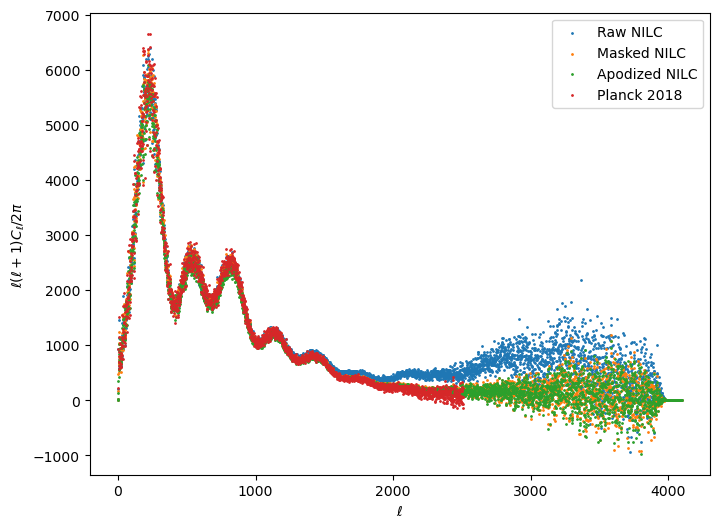

In [40]:
plt.figure(figsize=(8, 6))
plt.scatter(ells, (raw_nilc_dl - raw_noise_bias)*1e12,                    s = 1,label='Raw NILC')
plt.scatter(ells, (masked_nilc_dl - masked_noise_bias)*1e12,              s = 1,label='Masked NILC')
plt.scatter(ells, (apodized_filtered_nilc_dl - apodized_noise_bias)*1e12, s = 1,label='Apodized NILC')
plt.scatter(ell , planck_dl,label='Planck 2018', s = 1)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')
plt.legend()
plt.show()


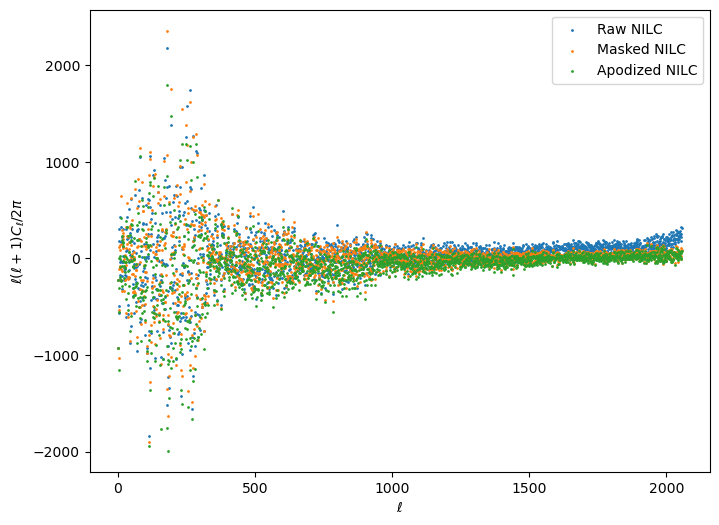

In [41]:
raw_abs_diff = abs_diff((raw_nilc_dl[:2057] - raw_noise_bias[:2057])*1e12, planck_dl[:2057])
masked_abs_diff = abs_diff((masked_nilc_dl[:2057] - masked_noise_bias[:2057])*1e12, planck_dl[:2057])
apodized_abs_diff = abs_diff((apodized_filtered_nilc_dl[:2057] - apodized_noise_bias[:2057])*1e12, planck_dl[:2057])

plt.figure(figsize=(8, 6))
plt.scatter(ells[:2057], raw_abs_diff,      s = 1, label='Raw NILC')
plt.scatter(ells[:2057], masked_abs_diff,   s = 1, label='Masked NILC')
plt.scatter(ells[:2057], apodized_abs_diff, s = 1, label='Apodized NILC')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')
plt.legend()
plt.show()

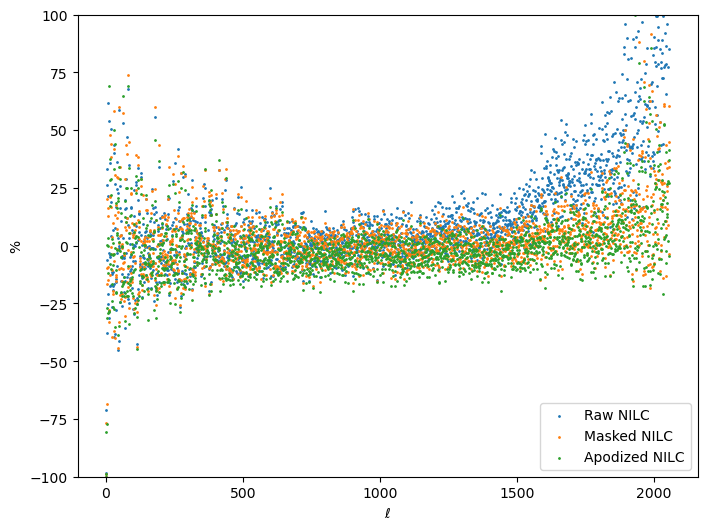

In [38]:
raw_ratio_diff = ratio_diff((raw_nilc_dl[:2057] - raw_noise_bias[:2057])*1e12, planck_dl[:2057])
masked_ratio_diff = ratio_diff((masked_nilc_dl[:2057] - masked_noise_bias[:2057])*1e12, planck_dl[:2057])
apodized_ratio_diff = ratio_diff((apodized_filtered_nilc_dl[:2057] - apodized_noise_bias[:2057])*1e12, planck_dl[:2057])

plt.figure(figsize=(8, 6))
plt.scatter(ells[:2057], raw_ratio_diff, s = 1,label='Raw NILC')
plt.scatter(ells[:2057], masked_ratio_diff, s = 1,label='Masked NILC')
plt.scatter(ells[:2057], apodized_ratio_diff, s = 1,label='Apodized NILC')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\%$')
plt.ylim(-100, 100)
plt.legend()
plt.show()